# Lesson 8 - Part 01

This is a reimplementation of fastai part 2 version 3 in Swift.
https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/01_matmul.ipynb

note: this requires my fork of [swift-jupyter](https://github.com/metachi/swift-jupyter) and a clone of my [TimeMagic](https://github.com/metachi/TimeMagic) repo for the ```%%time``` and ```%%timeit``` magic commands to work

In [2]:
%install '.package(path: "~/gitrepos/TimeMagic")' TimeMagic
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/JustHTTP/Just", from: "0.7.1")' Just

Installing packages:
	.package(path: "~/gitrepos/TimeMagic")
		TimeMagic
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/JustHTTP/Just", from: "0.7.1")
		Just
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 2.31s
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Compile Swift Module 'TimeMagic' (1 sources)
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Installation complete!

In [3]:
import TimeMagic
import Foundation
import Path
import Just

### Download Dataset

In [4]:
print(Path.home/".fastai"/"data"/"test.txt")

/home/jeff/.fastai/data/test.txt


In [5]:
public func download(_ url: String, dest: String){
    let r = Just.get(url, allowRedirects:false)
    do {
        try r.content!.write(to: URL.init(fileURLWithPath: dest))
    } catch {
        print("error downloading \(url)")
    }
}

In [6]:
let base = "http://yann.lecun.com/exdb/mnist/"
let trn_imgs = "train-images-idx3-ubyte"
let trn_lbls = "train-labels-idx1-ubyte"
let val_imgs = "t10k-images-idx3-ubyte"
let val_lbls = "t10k-labels-idx1-ubyte" 

In [7]:
let dest = Path.home/".fastai"/"data"/"mnist"

In [8]:
if !dest.exists{
    dest.mkdir()
}

In [9]:
for fileName in [trn_imgs, trn_lbls, val_imgs, val_lbls] {
    var destPath = dest/(fileName)
    if !destPath.exists{
        download("\(base)/\(fileName)", dest: destPath.string + ".gz")
    }
}

In [10]:
for n in dest.ls() {
    print(n.path)
}

/home/jeff/.fastai/data/mnist/t10k-labels-idx1-ubyte
/home/jeff/.fastai/data/mnist/train-labels-idx1-ubyte
/home/jeff/.fastai/data/mnist/train-images-idx3-ubyte
/home/jeff/.fastai/data/mnist/t10k-images-idx3-ubyte


gunzip the files

In [11]:
for n in dest.ls() {
    print(n.path)
}

/home/jeff/.fastai/data/mnist/t10k-labels-idx1-ubyte
/home/jeff/.fastai/data/mnist/train-labels-idx1-ubyte
/home/jeff/.fastai/data/mnist/train-images-idx3-ubyte
/home/jeff/.fastai/data/mnist/t10k-images-idx3-ubyte


### Load the dataset

In [12]:
import TensorFlow

See [Yann Lecunn's site](http://yann.lecun.com/exdb/mnist/) for info on why we have to drop the first few k bits.  See the "TRAINING SET LABEL FILE" heading and similarly named headings.

In [13]:
func loadData(path: String, shape: [Int32], is_label: Bool) -> Tensor<Float> {
    let dropK: Int = (is_label ? 8 : 16)
    let data = try! Data.init(contentsOf: 
                     URL.init(fileURLWithPath: path)
                    ).dropFirst(dropK)
    let tensorShape = TensorShape.init(shape)
    return Tensor(data.map(Float.init)).reshaped(to: tensorShape)
}

In [14]:
let xTrain: Tensor<Float> = loadData(path: (dest/trn_imgs).string,
                   shape: [60000, 784],
                   is_label: false)

In [15]:
let yTrain: Tensor<Float> = loadData(path: (dest/trn_lbls).string,
                   shape: [60000],
                   is_label: true)

In [16]:
let xValid: Tensor<Float> = loadData(path: (dest/val_imgs).string,
                   shape: [10000, 784],
                   is_label: false)

In [17]:
let yValid: Tensor<Float> = loadData(path: (dest/val_lbls).string,
                   shape: [10000],
                   is_label: true)

In [18]:
import Python

In [19]:
let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

In [20]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [21]:
let img = np.array(xTrain[0].array.scalars).reshape(28,28)

Label: 5.0


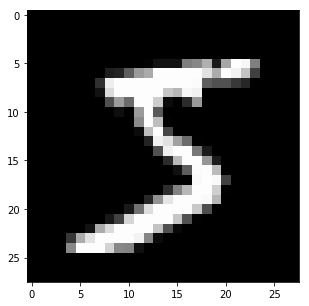

In [22]:
plt.figure(figsize: [5,5])
let fig = plt.imshow(X:img, cmap:"gray")
plt.show(fig)
print("Label: \(yTrain[0])")

### Initial Model

In [23]:
func getRandomWeights<G: RandomNumberGenerator>(shape: TensorShape,
                                   mean: Float = 0,
                                   stddev: Float = 1,
                                   generator: inout G) -> Tensor<Float> {
        let dist = NormalDistribution<Float>(mean: mean, standardDeviation: stddev)
        var scalars: [Float] = []
        for _ in 0 ..< shape.contiguousSize {
            scalars.append(dist.next(using: &generator))
        }
        return Tensor(shape: shape, scalars: scalars)
}

In [24]:
// simplified kaiming init / he init
var weights = getRandomWeights(shape: [784, 10],
                               mean: 0,
                               stddev: 1,
                               generator: &ThreefryRandomNumberGenerator.global)/sqrt(784)

In [25]:
weights[0]

[0.015692806, 0.018028047, -0.041229602, 0.017740957, 0.0024625212, -0.069348, -0.014167617, 0.011419489, 0.04176545, 0.0066351155]


In [26]:
var bias = Tensor<Float>(zeros: [10])

In [27]:
bias

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Matrix Multiply

In [28]:
var m1 = xValid.slice(lowerBounds: [0,0], upperBounds: [5,784])
var m2 = weights

In [29]:
m1.shape

▿ TensorShape
  ▿ dimensions : 2 elements
    - 0 : 5
    - 1 : 784


In [30]:
m2.shape[0]

784


In [31]:
func slowMatMul<Scalar: Numeric>(_ x: Tensor<Scalar>, _ y: Tensor<Scalar>) -> Tensor<Scalar> {
    let xr = x.shape[0]
    let xc = x.shape[1]
    let yr = y.shape[0]
    let yc = y.shape[1]
    assert(xc == yr)
    var z = Tensor<Scalar>(zeros: [xr, yc])
    for i in 0..<xr {
        for j in 0..<yc {
            for k in 0..<xc {
                z[i][j] += x[i][k] * y[k][j]
            }
        }
    }
    return z
}

quick test of slow matrix multiply
![img](imgs/mmul_ex.png)

In [32]:
slowMatMul(
    Tensor(rangeFrom: 0, to: 6, stride: 1).reshaped(to: [2,3]),
    Tensor(rangeFrom: 0, to: 12, stride: 2).reshaped(to: [3,2])
)

[[20.0, 26.0], [56.0, 80.0]]


In [32]:
%%timeit 4
var _ = slowMatMul(m1, m2)

Max: 219.917889293 seconds
Min: 214.322750312 seconds
Mean: 271.18748346525 seconds
Std Dev: 60.672921457676935 seconds


Elementwise Matrix Multiply

In [34]:
func elementWiseMatMul<Scalar: Numeric>(_ x: Tensor<Scalar>, _ y: Tensor<Scalar>) -> Tensor<Scalar> {
    let xr = x.shape[0]
    let xc = x.shape[1]
    let yr = y.shape[0]
    let yc = y.shape[1]
    assert(xc == yr)
    var z = Tensor<Scalar>(zeros: [xr, yc])
    for i in 0..<xr {
        for j in 0..<yc {
            z[i][j] = (x[i] * y.slice(lowerBounds: [0,j], upperBounds: [yr, j+1]).reshaped(to: [yr])).sum()
        }
    }
    return z
}

quick test of elementwise matrix multiply
![img](imgs/mmul_ex.png)

In [35]:
elementWiseMatMul(
    Tensor(rangeFrom: 0, to: 6, stride: 1).reshaped(to: [2,3]),
    Tensor(rangeFrom: 0, to: 12, stride: 2).reshaped(to: [3,2])
)

[[20.0, 26.0], [56.0, 80.0]]


In [36]:
%%timeit 50
// 1000 iterations takes too long...
var _ = elementWiseMatMul(m1, m2)

Max: 234.85611 ms
Min: 208.257666 ms
Mean: 222.98663768 ms
Std Dev: 6.6201291673389395 ms


### Broadcasting

In [37]:
var a = Tensor([10.0,  6.0, -4.0])

In [38]:
a

[10.0, 6.0, -4.0]


In [39]:
a .> 0

[true, true, false]


Broadcasting with scalars

In [39]:
a + 1

[11.0, 7.0, -3.0]


In [41]:
var m = Tensor(rangeFrom: 1, to: 10, stride: 1).reshaped(to: [3,3])

In [42]:
m

[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]


In [43]:
2*m

[[2.0, 4.0, 6.0], [8.0, 10.0, 12.0], [14.0, 16.0, 18.0]]


In [44]:
a .> m

[[true, true, false], [true, true, false], [true, false, false]]


Broadcasting with vectors

In [45]:
var c = Tensor([10.0, 20.0, 30.0]); c

[10.0, 20.0, 30.0]


In [46]:
m

[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]


In [47]:
print(m.shape); print(c.shape)

TensorShape(dimensions: [3, 3])
TensorShape(dimensions: [3])


In [48]:
m + c

[[11.0, 22.0, 33.0], [14.0, 25.0, 36.0], [17.0, 28.0, 39.0]]


In [49]:
c + m

[[11.0, 22.0, 33.0], [14.0, 25.0, 36.0], [17.0, 28.0, 39.0]]


At first glance, does not appear S4TF has an equivalent of the PyTorch ```Tensor.expand_as()```.  The closest thing to ```Tensor.storage()``` I could find is below.

In [50]:
c.scalarCount

3


No indexing with None like in numpy

In [51]:
c.expandingShape(at: 0)

[[10.0, 20.0, 30.0]]


In [52]:
c.expandingShape(at: 1)

[[10.0], [20.0], [30.0]]


In [53]:
m + c.expandingShape(at: 1)

[[11.0, 12.0, 13.0], [24.0, 25.0, 26.0], [37.0, 38.0, 39.0]]


Matrix Multiply with broadcasting

note: S4TF does not have a sum by axis (or min, or max...etc.)
we have to convert to np and back to accomplish this

In [54]:
Tensor<Float>(numpy: np.sum(m.makeNumpyArray(), axis:0, dtype: np.float32))

▿ Optional<Tensor<Float>>
  - some : [12.0, 15.0, 18.0]


In [55]:
Tensor<Float>(numpy: np.sum(m.makeNumpyArray(), axis:0, dtype: np.float32))

▿ Optional<Tensor<Float>>
  - some : [12.0, 15.0, 18.0]


In [56]:
func broadcastMatMul<Scalar: Numeric & NumpyScalarCompatible>(_ x: Tensor<Scalar>, _ y: Tensor<Scalar>) -> Tensor<Scalar> {
    let xr = x.shape[0]
    let xc = x.shape[1]
    let yr = y.shape[0]
    let yc = y.shape[1]
    assert(xc == yr)
    var z = Tensor<Scalar>(zeros: [xr, yc])
    for i in 0..<xr {
        z[i] = Tensor<Scalar>(numpy:
            np.sum((x[i].expandingShape(at: -1) * y).makeNumpyArray(),
                axis:0, dtype: Scalar.numpyScalarTypes[0]) //TODO: dynamically convert type
        )!
    }
    return z
}

quick test of broadcast matrix multiply
![img](imgs/mmul_ex.png)

In [57]:
broadcastMatMul(
    Tensor(rangeFrom: 0, to: 6, stride: 1).reshaped(to: [2,3]),
    Tensor(rangeFrom: 0, to: 12, stride: 2).reshaped(to: [3,2])
)

[[20.0, 26.0], [56.0, 80.0]]


In [58]:
%%timeit 50
// 1000 iterations takes too long...
var _ = broadcastMatMul(m1, m2)

Max: 23.226036 ms
Min: 11.779043 ms
Mean: 12.576188759999999 ms
Std Dev: 1.7539291271924728 ms


### Tensorflow Op

In [59]:
%%timeit 1000
var _ = matmul(m1, m2)

Max: 37.556 µs
Min: 10.021 µs
Mean: 10.306009 µs
Std Dev: 1.0657840927819664 µs
